In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def explode_variable(series,col):
    series = series.dropna()
    series = series.str.split(';')
    series = series.explode()
    series = series.str.strip()
    if 'DeveloperType'==col:
        devtype_dict = {'Developer, full-stack':'Full-stack developer',
                        'Developer, back-end':'Back-end developer',
                        'Developer, front-end':'Front-end developer',
                        'Developer, mobile':'Mobile developer'}
        series = series.replace(devtype_dict)
    if 'WebFrameWorkedWith'==col:
        web_dict = {'React':'React.js',
                    'Angular/Angular.js':'Angular.js',
                    'Angular':'Angular.js'}
        series = series.replace(web_dict)
    if 'DatabaseWorkedWith'==col:
        db_dict = {'Microsoft Azure (Tables, CosmosDB, SQL, etc)':'Microsoft Azure'}
        series = series.replace(db_dict)
    return series.unique().tolist()

def one_hot_cat_list(cat_list,series):
    one_hot = []
    for val in series.values:
        one_hot.append([1 if cat in str(val) else 0 for cat in cat_list])
    return pd.DataFrame(one_hot,columns=cat_list)

In [3]:
df_free = pd.read_csv('survey_data_17_to_19.csv',low_memory=False)
df_free.head()

,Employment,Country,Education,Major,DeveloperType,JobSatisfaction,Salary,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,WebFrameWorkedWith,Year
0,"Independent contractor, freelancer, or self-em...",France,Master's degree,Computer science or software engineering,Mobile developer; Desktop applications developer,Moderately dissatisfied,NaN,Objective-C; Swift,PostgreSQL,iOS; Amazon Web Services (AWS),NaN,2017
1,"Independent contractor, freelancer, or self-em...",U.S.,Primary/elementary school,NaN,Desktop applications developer,Moderately dissatisfied,NaN,JavaScript; VB.NET,NaN,Windows Desktop,NaN,2017
2,"Independent contractor, freelancer, or self-em...",Italy,Secondary school,NaN,Web developer,Moderately dissatisfied,NaN,PHP; SQL,MySQL,Windows Desktop; WordPress,NaN,2017
3,"Independent contractor, freelancer, or self-em...",Germany,Professional degree,Computer science or software engineering,NaN,NaN,NaN,C#; Java,NaN,Windows Desktop; Linux Desktop,NaN,2017
4,"Independent contractor, freelancer, or self-em...",Brazil,Some college/university study without earning ...,Computer science or software engineering,Web developer,Neither satisfied nor dissatisfied,NaN,JavaScript,MongoDB,NaN,Node.js; React; Firebase,2017


In [4]:
Q3 = df_free['Salary'].describe()['75%']
Q1 = df_free['Salary'].describe()['25%']
IQR = Q3-Q1
upper_bound = Q3 + 1.5*IQR

In [5]:
one_df = pd.DataFrame()
with_salary_no_outlier = (df_free['Salary']>0) & (df_free['Salary']<=upper_bound)
for col in ['DeveloperType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    
    cat_list = explode_variable(df_free[with_salary_no_outlier][col],col)
    dev_one_hot = one_hot_cat_list(cat_list,df_free[with_salary_no_outlier][col]).add_prefix(col+': ')

    one_df = pd.concat([one_df,dev_one_hot],axis=1)
    print(one_df.shape)

(3878, 20)
(3878, 58)
(3878, 79)
(3878, 105)
(3878, 117)


In [6]:
one_df['Salary']=df_free[with_salary_no_outlier].reset_index(drop=True)['Salary']
one_df.head()

,DeveloperType: Back-end developer,DeveloperType: Desktop or enterprise applications developer,DeveloperType: Front-end developer,DeveloperType: Full-stack developer,DeveloperType: QA or test developer,DeveloperType: DevOps specialist,DeveloperType: Student,"DeveloperType: C-suite executive (CEO, CTO, etc.)",DeveloperType: Database administrator,DeveloperType: Engineering manager,...,WebFrameWorkedWith: Node.js,WebFrameWorkedWith: Hadoop,WebFrameWorkedWith: Spark,WebFrameWorkedWith: Django,WebFrameWorkedWith: .NET Core,WebFrameWorkedWith: TensorFlow,WebFrameWorkedWith: Torch/PyTorch,WebFrameWorkedWith: Cordova,WebFrameWorkedWith: Xamarin,Salary
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78000.0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3500.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11500.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,150000.0
4,1,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,12.0


In [7]:
y_col = 'Salary'
Xs = one_df.drop(columns=y_col)
y = one_df[y_col]

X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.3,random_state=42)

In [8]:
model = LinearRegression()
model.fit(X_train,y_train)
preds = model.predict(X_test)
r2_score(y_test,preds),mean_squared_error(y_test,preds)

(0.07291015347065044, 2896065742.0943365)

In [9]:
feat_coef = pd.DataFrame(X_train.columns,columns=['Feature'])
feat_coef = feat_coef.set_index('Feature')
feat_coef['Coefficient'] = model.coef_

Text(0.5, 1.0, 'DeveloperType')

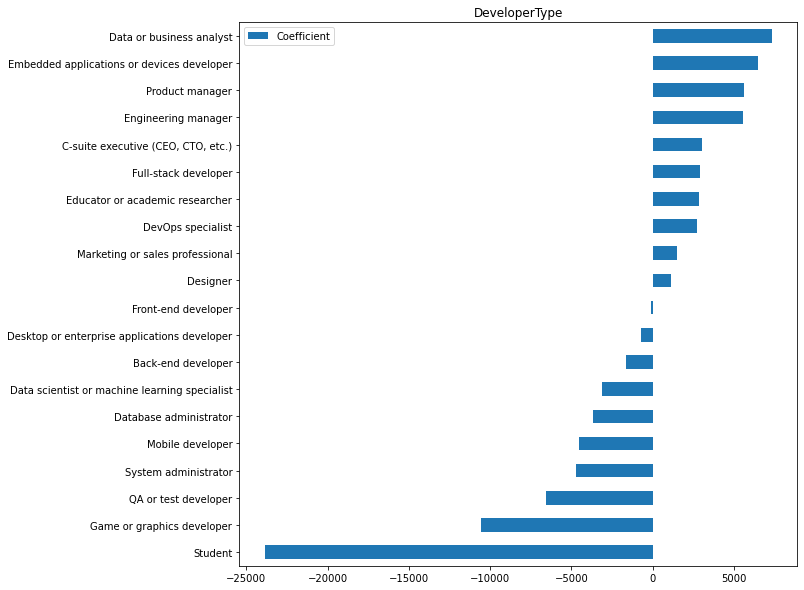

In [14]:
contains_col = feat_coef.index.str.contains('DeveloperType')
sub_feat = feat_coef[contains_col]
sub_feat.index = sub_feat.index.str.replace('DeveloperType'+': ','')
sub_feat.sort_values('Coefficient').plot(kind='barh',figsize=(10,10))
plt.ylabel('')
plt.title('DeveloperType')

In [11]:
contains_col = feat_coef.index.str.contains('DatabaseWorkedWith')
sub_feat = feat_coef[contains_col]
sub_feat.index.values

array(['DatabaseWorkedWith: SQL Server', 'DatabaseWorkedWith: Redis',
       'DatabaseWorkedWith: PostgreSQL', 'DatabaseWorkedWith: Memcached',
       'DatabaseWorkedWith: Google Cloud Storage',
       'DatabaseWorkedWith: Oracle', 'DatabaseWorkedWith: MongoDB',
       'DatabaseWorkedWith: MySQL', 'DatabaseWorkedWith: Elasticsearch',
       'DatabaseWorkedWith: Cassandra', 'DatabaseWorkedWith: SQLite',
       'DatabaseWorkedWith: Neo4j', 'DatabaseWorkedWith: Microsoft Azure',
       'DatabaseWorkedWith: MariaDB',
       'DatabaseWorkedWith: Amazon DynamoDB',
       'DatabaseWorkedWith: Amazon RDS/Aurora',
       'DatabaseWorkedWith: Google BigQuery',
       'DatabaseWorkedWith: IBM Db2',
       'DatabaseWorkedWith: Amazon Redshift',
       'DatabaseWorkedWith: Apache HBase',
       'DatabaseWorkedWith: Apache Hive'], dtype=object)

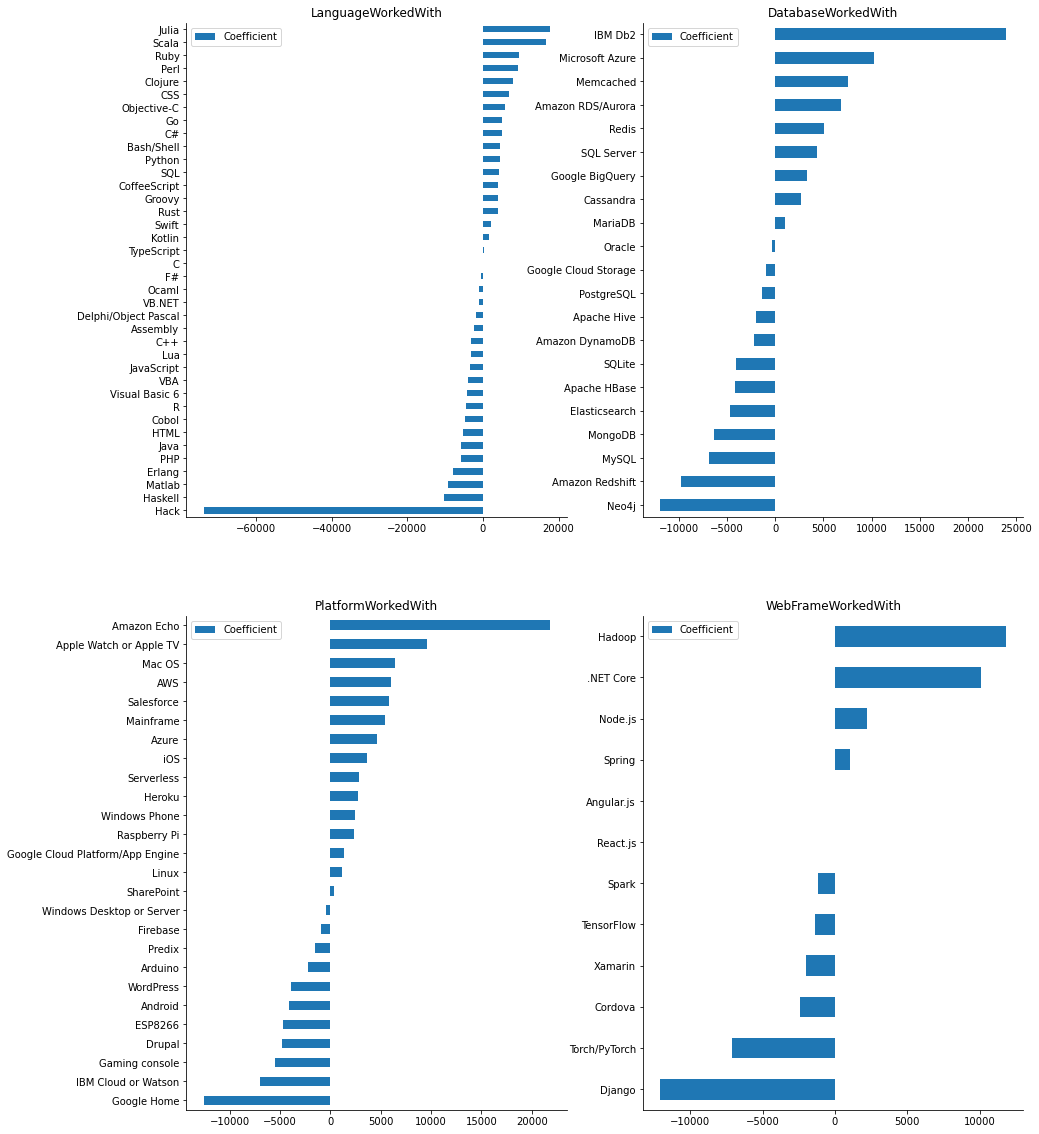

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

In [12]:
fig, ax = plt.subplots(2,2,figsize=(15,20))

a = 0
b = 0

for col in ['LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','WebFrameWorkedWith']:
    plt.figure(figsize=(3,10))
    contains_col = feat_coef.index.str.contains(col)
    sub_feat = feat_coef[contains_col]
    sub_feat.index = sub_feat.index.str.replace(col+': ','')
    sub_feat.sort_values('Coefficient').plot(kind='barh',ax=ax[a,b])
    ax[a,b].spines['right'].set_visible(False)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].set_ylabel('')
    ax[a,b].set_title(str(col));
    b+=1
    if(b==2):
        b=0
        a+=1
plt.show();